This is the notebook for event-driven alpha research

In [1]:
import pandas as pd 
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Read dataset

In [2]:
eps = pd.read_parquet('processed_eps.parquet')
stock = pd.read_parquet('processed_stock.parquet')

In [19]:
# how many tradays in this study
print(f'Total tradays: {stock.Trddt.nunique()}')
print(stock.Trddt.unique())

Total tradays: 2430
['2013-01-04T00:00:00.000000000' '2013-01-07T00:00:00.000000000'
 '2013-01-08T00:00:00.000000000' ... '2022-12-30T00:00:00.000000000'
 '2013-09-06T00:00:00.000000000' '2014-07-15T00:00:00.000000000']


Now set indicator for the event in backtesting

In [4]:
@njit(cache=True)
def _calculate_car_and_indicator(ars_arr, event_idx, window_size=120):
    """
    Performing slice, CAR, and Indicator on a ARs array 

    ----
    Param:

    ars_arr: ARs array of a stock

    event_idx: the index of the event date in ars_arr

    window_size: the size of slicing window, how many tradays before/after the event

    ----
    Return: 

    tuple: (CAR_arr, Indicator_arr) or (None, None) for insufficient window
    """
    total_len = len(ars_arr)
    # set the beginning and the end of arr

    # Before: 120 days up to the date before the nearest index
    before_end = event_idx
    before_start = max(0, before_end - window_size)   

    # After: 121 days starting from the nearest index
    after_start = event_idx
    after_end = min(total_len, after_start + window_size + 1)

    # check len of before
    if (before_end - before_start < window_size):
        return None, None, None
    # check len of after
    if (after_end - after_start < window_size + 1):
        if (after_end - after_start < 120):
            return None, None, None
    
    before_ars = ars_arr[before_start : before_end]
    after_ars = ars_arr[after_start : after_end]
    window_ars = np.concatenate((before_ars, after_ars))

    # CAR
    car = np.cumsum(window_ars)
    # indicator
    total_window_len = len(window_ars)
    indicator = np.arange(-window_size, total_window_len - window_size)

    return car, indicator, window_ars

def _process_event_window(eps_row, stock_df, stock_map, window_size=120):
    """
    Process each event row, look up all matched stock data
    """
    event_id = eps_row['id']
    
    if event_id not in stock_map:
        return None
    
    start_global_iloc, end_global_iloc = stock_map[event_id]
    stock_sub_df = stock_df.iloc[start_global_iloc: end_global_iloc].copy()

    if stock_sub_df.empty:
        return None
    
    announce_date = eps_row['announce'].to_datetime64()

    trddt_arr = stock_sub_df['Trddt'].values
    event_idx = trddt_arr.searchsorted(announce_date)
    ars_arr = stock_sub_df['ARs'].values
    car_arr, indicator_arr, window_ars = _calculate_car_and_indicator(ars_arr, event_idx, window_size)

    if car_arr is None:
        return None
    
    window_len = len(car_arr)

    start_idx_in_sub_df = max(0, event_idx - window_size)
    end_idx_in_sub_df = start_idx_in_sub_df + window_len

    result_data = stock_sub_df.iloc[start_idx_in_sub_df: end_idx_in_sub_df].copy()
    result_data['ARs'] = window_ars
    result_data['CAR'] = car_arr
    result_data['indicator'] = indicator_arr
    result_data['SUE decile'] = eps_row['SUE decile']
    result_data['announce'] = eps_row['announce']

    return result_data

In [5]:
stock['id'] = stock['Stkcd']
stock = stock.sort_values(by=['id', 'Trddt'])
stock['Trddt'] = pd.to_datetime(stock['Trddt'])
eps['announce'] = pd.to_datetime(eps['announce'])
# build a map for faster look-up
unique_ids = stock['id'].unique()
id_locs = np.searchsorted(stock['id'].values, unique_ids)
stock_index_map = {
    unique_ids[i]: (id_locs[i], id_locs[i+1] if i + 1 < len(id_locs) else len(stock)) 
    for i in range(len(unique_ids))
}

results_list = eps.apply(
    lambda row: _process_event_window(row, stock, stock_index_map, 120), 
    axis=1
)
results_list = results_list.dropna().tolist()

if results_list:
    result_df = pd.concat(results_list, ignore_index=True)
else:
    result_df = pd.DataFrame()

In [6]:
sue_data_by_group = result_df[['id', 'SUE decile', 'CAR', 'indicator', 'ARs']]
sue_data_by_group = sue_data_by_group.rename(columns={'SUE decile': 'decile'})
sue_data_by_group.head()

,id,decile,CAR,indicator,ARs
0,1,4,-0.037445,-120,-0.037445
1,1,4,-0.021643,-119,0.015802
2,1,4,-0.042955,-118,-0.021312
3,1,4,0.030864,-117,0.073819
4,1,4,0.070294,-116,0.039430


Turn into vectorize dataset for cross-sectional comparision

In [7]:
def cs_mean(dataset, factor_name='CAR'):
    factor_dataframe = pd.DataFrame()
    groups = dataset.groupby('decile')
    for decile, group in groups:
        mean_cs = group.groupby('indicator')[factor_name].mean()
        factor_dataframe[decile] = mean_cs
    
    factor_dataframe.reset_index(inplace=True)
    return factor_dataframe

In [8]:
sue_cs_mean_dataset = cs_mean(sue_data_by_group, 'CAR')
sue_cs_mean_dataset.head()

,indicator,1,2,3,4,5,6,7,8,9,10
0,-120,-0.000267,-0.000826,-0.001221,-0.000753,-0.000650,-0.000909,-0.000026,-0.000243,-0.000705,-0.001039
1,-119,-0.000538,-0.001480,-0.001899,-0.000963,-0.001417,-0.001786,0.000207,-0.000229,-0.000652,-0.000876
2,-118,-0.000535,-0.002031,-0.002165,-0.001827,-0.001000,-0.002739,0.000136,-0.001265,0.000183,-0.000885
3,-117,-0.001196,-0.002250,-0.003527,-0.002627,-0.001585,-0.003185,-0.000476,-0.000799,0.000197,-0.001009
4,-116,-0.001726,-0.002652,-0.004089,-0.003288,-0.001509,-0.004038,-0.000168,-0.001144,-0.000276,-0.000992


Effects of the event on portfolio returns

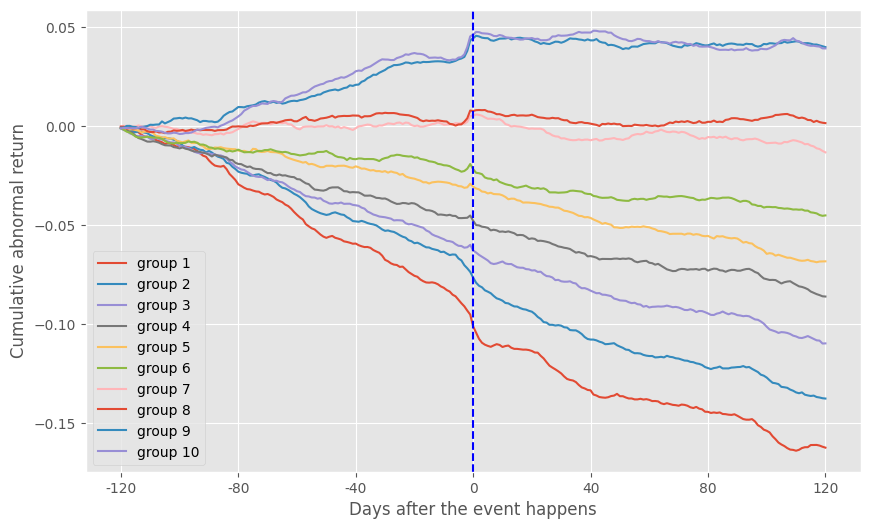

In [9]:
def group_show(group_frame):
    plt.figure(figsize=(10, 6))
    plt.style.use('ggplot')
    for group in group_frame.columns[1:]:
        plt.plot(group_frame['indicator'], group_frame[group], label=f'group {group}')

    xticks = [-120, -80, -40, 0, 40, 80, 120]
    plt.xticks(xticks, xticks)
    plt.axvline(x=0, color='blue', linestyle='--')
    plt.legend()
    plt.xlabel('Days after the event happens')
    plt.ylabel('Cumulative abnormal return')
    plt.show()

group_show(sue_cs_mean_dataset)

## Findings:

- **Signal Effectiveness**: The ten groups exhibit a pronounced and systematic separation in their Cumulative Abnormal Returns (CARs) throughout the entire event window.
- **Post-Event Drift**: Price adjustment is not instantaneous after the announcement.
- **Pre-Event Information Leakage**: The significant divergence in CARs before the event date indicates that the market was already pricing in the upcoming positive or negative information.

## Alpha Design

- Both high SUE and low SUE are driven by Post-Earnings Announcement Drift, PEAD

- Long group 10

- Short group 1

- Rebalance on each announcement date, i.e., fiscal quarter, since we cannot be a front-runner

- Equal-weighted for stocks in each group we trade in

In [15]:
def prepare_backtest(origin_result_df, stock):
    # rename, if not necessary then commit the following line
    result_df = origin_result_df.rename(columns={'SUE decile': 'decile'})
    backtest_map = result_df[['id', 'Trddt', 'decile', 'indicator']].copy()
    backtest_map.drop_duplicates(subset=['id', 'Trddt'], inplace=True)
    stock_returns = stock[['id', 'Trddt', 'Dretwd']].copy()
    final_backtest_df = pd.merge(
        stock_returns, 
        backtest_map, 
        on=['id', 'Trddt'], 
        how='inner')
    # cannot trade before the rebalance date
    final_backtest_df.loc[final_backtest_df['indicator'] < 0, 'decile'] = np.nan
    return final_backtest_df

def event_factor_backtest(backtest_df):
    """
    Test alpha by the dataset `event_alpha`, long-short & pure long
    """
    long_group = backtest_df[backtest_df['decile'] == 10]
    short_group = backtest_df[backtest_df['decile'] == 1]
    long_returns = long_group.groupby('Trddt')['Dretwd'].mean().rename('daily_long')
    short_returns = short_group.groupby('Trddt')['Dretwd'].mean().rename('daily_short')
    daily_returns = pd.merge(long_returns, short_returns, left_index=True, right_index=True, how='outer').fillna(0)
    daily_returns['daily_long_short'] = daily_returns['daily_long'] - daily_returns['daily_short']
    daily_returns['pure_long'] = daily_returns['daily_long'].cumsum()
    daily_returns['long_short'] = daily_returns['daily_long_short'].cumsum()

    return daily_returns

def plot_alpha(factor_bt):
    plt.style.use('ggplot')
    plt.figure(figsize=(15, 6))
    plt.plot(factor_bt.index, factor_bt['long_short'], label='Long Short')
    plt.plot(factor_bt.index, factor_bt['pure_long'], label='Long Only')
    plt.axhline(y=0, color='grey', linestyle='--', linewidth=1.5)
    plt.xlabel('Time')
    plt.ylabel('Simple Returns')
    plt.title('PEAD factor')
    plt.legend()
    plt.grid(True)
    plt.show()

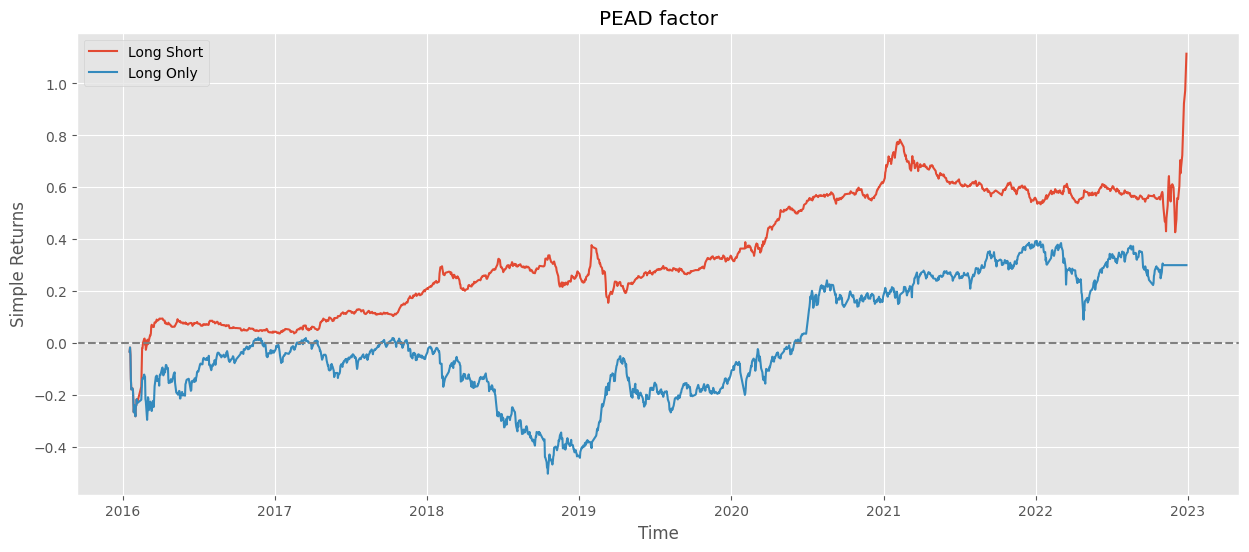

In [16]:
backtest_df = prepare_backtest(result_df, stock)
event_backtest = event_factor_backtest(backtest_df)
plot_alpha(event_backtest)

In [12]:
from metric import show_pnl

,From,To,SR,AnnRT,AnnVol,AvgDD,MaxDD,MaxDDStart,MaxDDEnd
2016,2016-01-18,2016-12-30,-0.2643,-7.83%,29.65%,10.49%,25.70%,2016-01-19,2016-02-29
2017,2017-01-03,2017-12-29,-0.1733,-2.55%,14.69%,5.18%,14.50%,2017-03-16,2017-06-01
2018,2018-01-02,2018-12-28,-1.4289,-34.70%,24.29%,20.94%,40.08%,2018-01-09,2018-10-18
2019,2019-01-02,2019-12-31,1.6192,34.64%,21.39%,9.60%,20.32%,2019-04-10,2019-08-09
2020,2020-01-02,2020-12-31,1.438,33.06%,22.99%,4.10%,12.67%,2020-03-05,2020-03-23
2021,2021-01-04,2021-12-31,1.461,23.00%,15.74%,1.99%,6.97%,2021-09-13,2021-10-28
2022,2022-01-04,2022-12-29,-0.5138,-11.36%,22.10%,10.00%,27.07%,2022-01-04,2022-04-26
ALL,2016-01-18,2022-12-29,0.0929,2.05%,22.02%,12.52%,42.90%,2016-01-19,2018-10-18


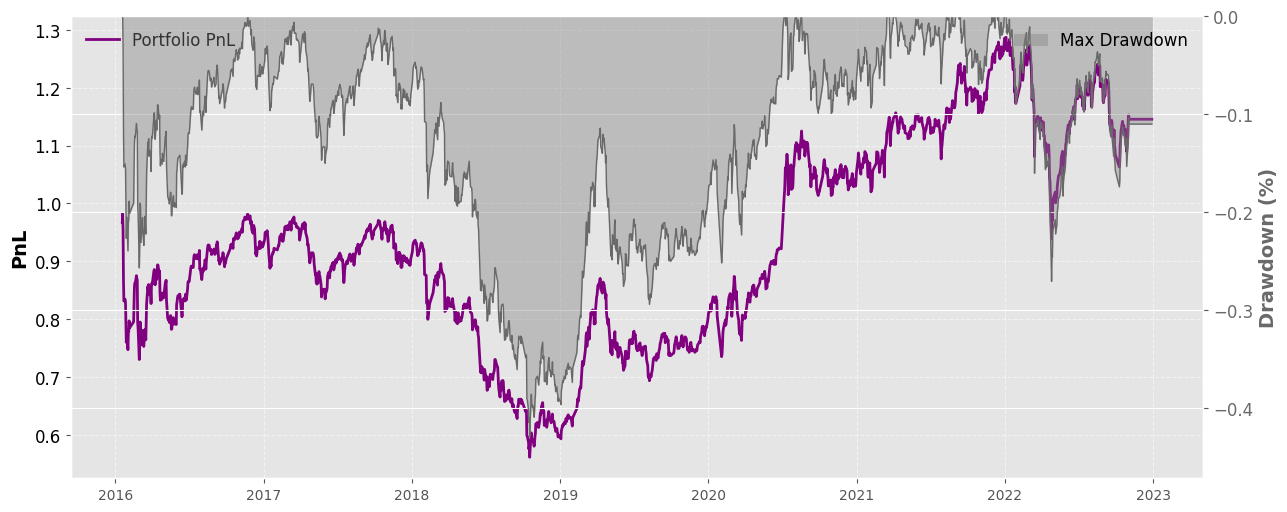

In [13]:
show_pnl(event_backtest['daily_long'])

,From,To,SR,AnnRT,AnnVol,AvgDD,MaxDD,MaxDDStart,MaxDDEnd
2016,2016-01-18,2016-12-30,0.1139,2.45%,21.50%,3.45%,23.97%,2016-01-19,2016-02-01
2017,2017-01-03,2017-12-29,3.3605,18.12%,5.39%,0.70%,2.62%,2017-07-21,2017-10-12
2018,2018-01-02,2018-12-28,0.6979,6.97%,9.99%,4.16%,11.53%,2018-10-22,2018-11-22
2019,2019-01-02,2019-12-31,0.4907,5.73%,11.68%,9.17%,20.10%,2019-01-31,2019-03-12
2020,2020-01-02,2020-12-31,3.3121,33.11%,10.00%,1.19%,5.17%,2020-02-04,2020-02-25
2021,2021-01-04,2021-12-31,-0.5097,-6.58%,12.91%,13.35%,21.78%,2021-02-09,2021-12-21
2022,2022-01-04,2022-12-29,2.5619,71.71%,27.99%,3.76%,20.06%,2022-11-17,2022-12-02
ALL,2016-01-18,2022-12-29,1.0429,16.58%,15.90%,7.59%,31.68%,2021-02-09,2022-12-02


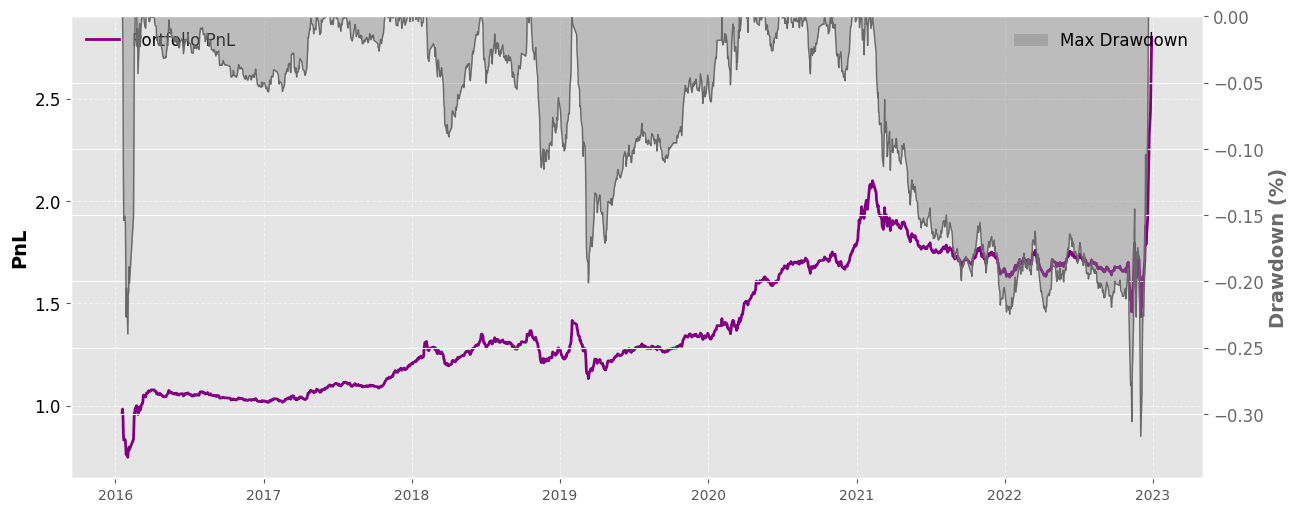

In [14]:
show_pnl(event_backtest['daily_long_short'])

### Long Alpha Enhancement

Only trade stocks in SZ50 or HS300 for the long-only portfolio:

- large cap

- best liquidity

In [63]:
hs300_w = pd.read_csv('hs300_index_weights.csv', usecols=['Stkcd', 'Trddt', 'weight'])
hs300_w['Trddt'] = pd.to_datetime(hs300_w['Trddt'])
hs300_w = hs300_w.sort_values(by=['Stkcd', 'Trddt'])
hs300_w

,Stkcd,Trddt,weight
579900,1,2013-09-30,0.960
580200,1,2013-09-30,0.960
580500,1,2013-09-30,0.960
580800,1,2013-09-30,0.960
581100,1,2013-09-30,0.960
...,...,...,...
653393,688981,2022-11-30,0.439
655193,688981,2022-11-30,0.439
661493,688981,2022-11-30,0.439
661793,688981,2022-11-30,0.439


Prepare coverage of our signal to the HS300 index

In [64]:
index_coverage = result_df.copy()
index_coverage = pd.merge(
    index_coverage,
    hs300_w,
    on=['Stkcd', 'Trddt'],              
    how='left')          
index_coverage['weight'].fillna(0, inplace=True)
index_coverage.head(10)        

,Stkcd,Trddt,Dretwd,Cdretwdeq,ARs,id,CAR,indicator,SUE decile,announce,weight
0,1,2015-09-09,0.009091,0.046536,-0.037445,1,-0.037445,-120,4,2016-03-10,0.0
1,1,2015-09-10,-0.004505,-0.020307,0.015802,1,-0.021643,-119,4,2016-03-10,0.0
2,1,2015-09-11,-0.008145,0.013167,-0.021312,1,-0.042955,-118,4,2016-03-10,0.0
3,1,2015-09-14,-0.008212,-0.082031,0.073819,1,0.030864,-117,4,2016-03-10,0.0
4,1,2015-09-15,-0.027599,-0.067029,0.039430,1,0.070294,-116,4,2016-03-10,0.0
5,1,2015-09-16,0.031220,0.087683,-0.056463,1,0.013831,-115,4,2016-03-10,0.0
6,1,2015-09-17,-0.011927,-0.024188,0.012261,1,0.026092,-114,4,2016-03-10,0.0
7,1,2015-09-18,0.003714,0.015560,-0.011846,1,0.014246,-113,4,2016-03-10,0.0
8,1,2015-09-21,0.000925,0.044002,-0.043077,1,-0.028831,-112,4,2016-03-10,0.0
9,1,2015-09-22,0.012939,0.010897,0.002042,1,-0.026789,-111,4,2016-03-10,0.0


In [74]:
def index_backtest(origin_result_df, stock):
    # rename, if not necessary then commit the following line
    result_df = origin_result_df.rename(columns={'SUE decile': 'decile'})
    backtest_map = result_df[['id', 'Trddt', 'decile', 'indicator', 'weight']].copy()
    backtest_map.drop_duplicates(subset=['id', 'Trddt'], inplace=True)
    stock_returns = stock[['id', 'Trddt', 'Dretwd']].copy()
    final_backtest_df = pd.merge(
        stock_returns, 
        backtest_map, 
        on=['id', 'Trddt'], 
        how='inner')
    # cannot trade before the rebalance date
    final_backtest_df.loc[final_backtest_df['indicator'] < 0, 'decile'] = np.nan
    return final_backtest_df

def event_factor_backtest_coverage_on_index(backtest_df):
    """
    Test alpha by the dataset `event_alpha`, long-short & pure long
    """
    tradable_df = backtest_df[backtest_df['weight'] != 0].copy()
    long_group = tradable_df[tradable_df['decile'] == 10].copy()
    def weighted_mean(group):
        weight_sum = group['weight'].sum()
        if weight_sum == 0:
            return 0
        return (group['Dretwd'] * group['weight']).sum() / weight_sum
    long_returns = long_group.groupby('Trddt').apply(weighted_mean).rename('daily_long')
    short_group = tradable_df[tradable_df['decile'] == 1].copy()
    short_returns = short_group.groupby('Trddt').apply(weighted_mean).rename('daily_short')
    daily_returns = pd.merge(
        long_returns, 
        short_returns, 
        left_index=True, 
        right_index=True, 
        how='outer'
    ).fillna(0)
    daily_returns['daily_long_short'] = daily_returns['daily_long'] - daily_returns['daily_short']
    daily_returns['pure_long'] = daily_returns['daily_long'].cumsum()
    daily_returns['long_short'] = daily_returns['daily_long_short'].cumsum()
    return daily_returns

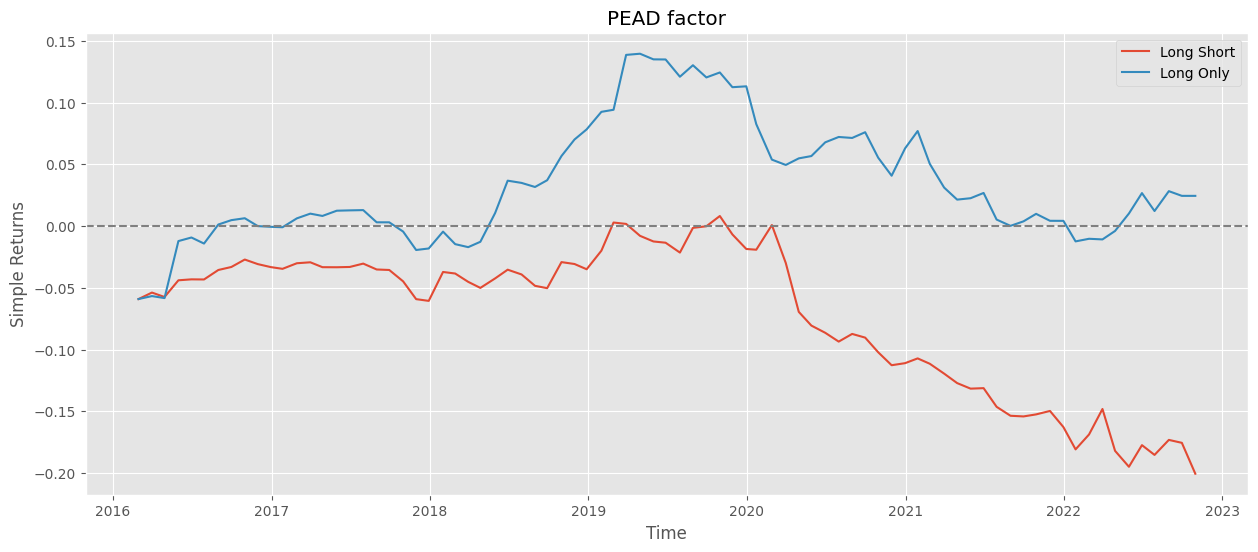

In [75]:
index_backtest_df = index_backtest(index_coverage, stock)
event_backtest_index_coverage = event_factor_backtest_coverage_on_index(index_backtest_df)
plot_alpha(event_backtest_index_coverage)

,From,To,SR,AnnRT,AnnVol,AvgDD,MaxDD,MaxDDStart,MaxDDEnd
2016,2016-02-29,2016-12-30,-0.2055,-7.96%,38.74%,0.18%,0.69%,2016-10-31,2016-12-30
2017,2017-01-26,2017-12-29,-3.1037,-31.14%,10.03%,0.85%,3.20%,2017-07-31,2017-11-30
2018,2018-01-31,2018-12-28,35.2213,639.96%,18.17%,0.32%,1.25%,2018-01-31,2018-03-30
2019,2019-01-31,2019-12-31,4.1569,102.14%,24.57%,1.04%,2.70%,2019-04-30,2019-11-29
2020,2020-01-23,2020-12-31,-2.5748,-66.30%,25.75%,2.08%,4.17%,2020-01-23,2020-11-30
2021,2021-01-29,2021-12-31,-3.6516,-71.43%,19.56%,5.44%,7.47%,2021-01-29,2021-08-31
2022,2022-01-28,2022-10-31,3.4243,63.87%,18.65%,0.23%,1.45%,2022-06-30,2022-07-29
ALL,2016-02-29,2022-10-31,0.2102,4.96%,23.62%,4.80%,14.35%,2019-04-30,2022-01-28


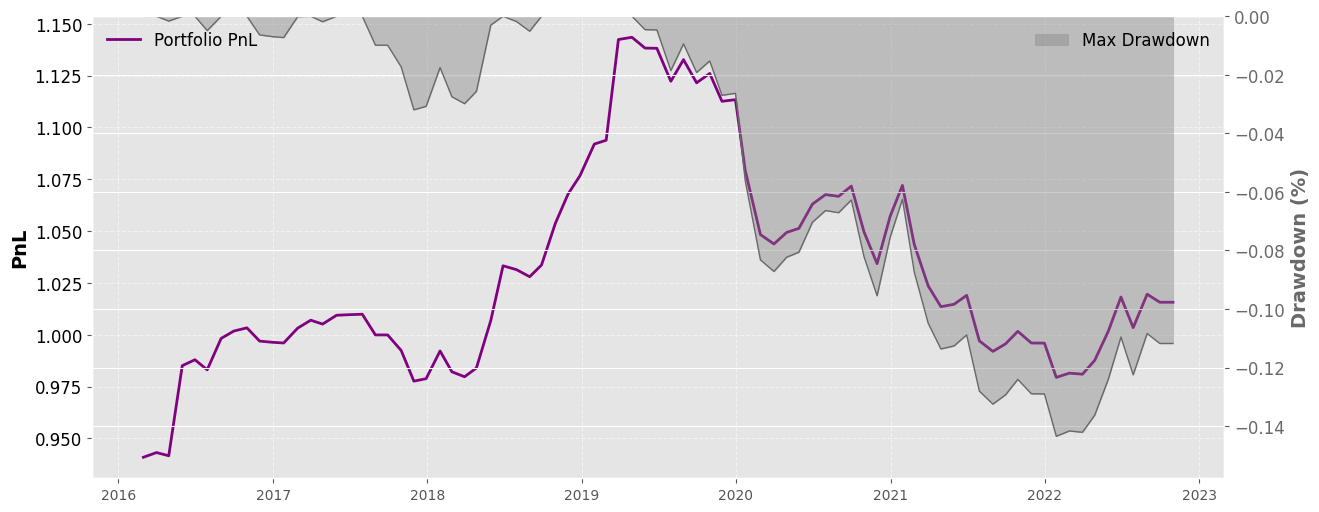

In [77]:
show_pnl(event_backtest_index_coverage['daily_long'])

- Pros: This method lowers the max-dd in the long-only portfolio

- Cons: Also deducts the usage in capital